<a href="https://colab.research.google.com/github/mastoffel/neural_vocoder/blob/main/neural_vocoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A neural vocoder for meows

<img src="https://drive.google.com/uc?id=1-Dyeq_Sz3kMWOUpP9MXmvRsWKXA7t0rh" alt="My Image" width=500>

*A stern looking cat wearing a futuristic glowing voice decoder*, Dall-E

### Overview
Most sound-processing neural networks (NNs) use spectrograms rather than raw waveforms as input. However, how do we go back to actual sound? **Neural Vocoders** reconstruct waveforms from spectrograms. This is not straightforward as phase information is somewhat lost when constructing the spectrogram. 

But there are ways to do it:
- Griffin Lim Algorithm 
- Autoregressive NNs: WaveNet, WaveRNN
- GANs: MelGAN, WaveGAN
- Diffusion (WaveGrad, DiffWave)

All these models are either quite complex or not a NN (Griffin-Lim). They vary quite a bit in their performance, as we can hear [here](https://mlr.cdn-apple.com/video/spectrogram_inversion_0e350e19d5.mp4). I wondered, whether a simpler NN architecture can be sufficient to get decent results. For example, [this paper](https://arxiv.org/abs/1808.06719) suggests that we can reconstruct a waveform from a simpler model using upsampling based on transposed convolutions. 

Let's try that.


In [152]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import os
import librosa
import random
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from librosa import power_to_db
from IPython.display import Audio
from os import listdir
#from torchinfo import summary
%matplotlib inline

In [153]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using {device}')

Using cuda


Easily plot raw waveforms and decibel-transformed spectrograms.

In [154]:
def plot_waveform(waveform, sr=8000):
    waveform = waveform.detach().cpu()
    num_frames = waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr
    plt.figure(figsize=(5, 3))
    plt.title("Waveform")
    plt.plot(time_axis, waveform.t().numpy())
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")


def plot_spectrogram(specgram):
    spectrogram = specgram.detach().cpu()
    plt.figure(figsize=(5, 3))
    plt.imshow(librosa.power_to_db(spectrogram), origin="lower", aspect="auto")
    plt.colorbar(format="%+2.f")
    plt.xlabel("Time frame")
    plt.ylabel("Frequency")
    plt.title("Spectrogram (db)")

### Download meows

In [155]:
!wget https://zenodo.org/record/4008297/files/dataset.zip?download=1 &> /dev/null
!unzip /content/dataset.zip?download=1 &> /dev/null

### Meows data
- 440 meows
- 3 contexts (brushing, isolation, waiting for food)
- 21 cats, 2 breeds

**Questions**:

- how long are the recordings?
- how many channels?
- what are the sample rates?

signal length min: 8684, max: 32012
signal channels min: 1, max: 1
sample rate min: 8000, max: 8000
Example signal min: -0.17, max: 0.13


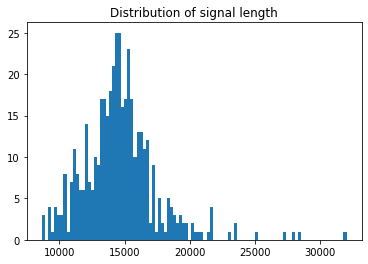

In [156]:
# check information for all wav files
wavs = [os.path.join('dataset/', file) for file in listdir('dataset/')]
#for wav in listdir('dataset/')
sig_len = []
sig_channels = []
srs = []
for wav in wavs:
    signal, sr = torchaudio.load(wav)
    sig_len.append(signal.shape[1])
    sig_channels.append(signal.shape[0])
    srs.append(sr)

print(f'signal length min: {min(sig_len)}, max: {max(sig_len)}')
print(f'signal channels min: {min(sig_channels)}, max: {max(sig_channels)}')
print(f'sample rate min: {min(srs)}, max: {max(srs)}')
print(f'Example signal min: {torch.min(signal):.2f}, max: {torch.max(signal):.2f}')

# check wav length to decide for a fixed length
plt.hist(sig_len, bins=100)
plt.title('Distribution of signal length')
plt.show()

### Create dataset

In [157]:
class Meows(Dataset):
    """Generate meow dataset.
      Args:
        audio_dir (str): Path to audio directory.
        transform (torchvision.transforms): Transform to apply to audio.
        num_samples (int): Number of samples to cut or pad to.
        target_sample_rate (int): Target sample rate.
        device (torch.device): Device to load data to.

      Returns:
        torch.utils.data.Dataset: Dataset of meows. 
        Tuple with spectrogram and raw signal (waveform).
    """ 

    def __init__(self, 
                 audio_dir, 
                 transform=None, 
                 num_samples=20000,
                 target_sample_rate=8000,
                 device=device):
        self.audio_dir = audio_dir
        self.device = device
        self.files = [f for f in listdir(audio_dir)]
        self.transform = transform.to(self.device)
        self.num_samples = num_samples
        self.target_sample_rate = target_sample_rate
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        path = os.path.join(self.audio_dir, file)
        signal, sr = torchaudio.load(path)
        signal.to(self.device)
        signal = self._resample(signal, sr)
        signal = self._cut_if_too_long(signal)
        signal = self._right_pad_if_too_short(signal)
        spec = self.transform(signal.to(self.device))
        raw_signal = signal.flatten()
        return spec.squeeze().to(self.device), raw_signal.to(self.device)
    
    def _cut_if_too_long(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_too_short(self, signal):
        if signal.shape[1] < self.num_samples:
            last_dim_pad = (0, self.num_samples - signal.shape[1])
            signal = torch.nn.functional.pad(signal, last_dim_pad)
        return signal
    
    def _resample(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

### Spectrogram
I'll use a simple spectogram for this analysis rather an additional transformation
like the mel scale.

In [158]:
# spectrogram transform. 

n_fft = 1024
win_length = 1024
hop_length = 256

spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_length, 
                         hop_length=hop_length)

### MeowNet 

In [159]:
class MeowNet(nn.Module):
    def __init__(self, spec_frames):
        super(MeowNet, self).__init__()
        self.spec_channel = spec_frames

        self.meownet = nn.Sequential(
            nn.ReflectionPad1d(3),
            nn.utils.weight_norm(nn.Conv1d(spec_frames, 512, kernel_size=7, stride=1)),
      
            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(512, 256, kernel_size=16, stride=8, padding=4)),

            nn.Dropout(0.5), 

            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(256, 128, kernel_size=16, stride=8, padding=4)),

            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)),

            nn.LeakyReLU(0.2),
            nn.utils.weight_norm(nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)),

            nn.LeakyReLU(0.2),
            nn.ReflectionPad1d(3),
            nn.utils.weight_norm(nn.Conv1d(32, 1, kernel_size=7, stride=1)),
            nn.Tanh(),
        )

    def forward(self, mel):
        out = self.meownet(mel)
        out = out.squeeze(1)[:, :20000]
        return out

In [160]:
meow = Meows(audio_dir='dataset/', transform=spectrogram)

# split into train and test
train_size = int(0.7 * len(meow))
test_size = len(meow) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(meow, [train_size, test_size]) 

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [161]:
meownet = MeowNet(513).to(device)

In [162]:
from torchsummary import summary
spec, signal = next(iter(train_loader))
print(spec.shape)
summary(meownet, (513, 79))

torch.Size([32, 513, 79])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad1d-1              [-1, 513, 85]               0
            Conv1d-2              [-1, 512, 79]       1,839,104
         LeakyReLU-3              [-1, 512, 79]               0
   ConvTranspose1d-4             [-1, 256, 632]       2,097,408
           Dropout-5             [-1, 256, 632]               0
         LeakyReLU-6             [-1, 256, 632]               0
   ConvTranspose1d-7            [-1, 128, 5056]         524,416
         LeakyReLU-8            [-1, 128, 5056]               0
   ConvTranspose1d-9            [-1, 64, 10112]          32,832
        LeakyReLU-10            [-1, 64, 10112]               0
  ConvTranspose1d-11            [-1, 32, 20224]           8,224
        LeakyReLU-12            [-1, 32, 20224]               0
  ReflectionPad1d-13            [-1, 32, 20230]               0
           Co

In [163]:
def loss_fn(out_signal, in_spec):
  eps = 0.00001
  out_spec = spectrogram(out_signal)
  spec1 = torch.log(abs(out_spec) + eps)
  spec2 = torch.log(abs(in_spec) + eps)
  loss = nn.L1Loss()
  #loss = nn.MSELoss()
  return loss(spec1, spec2)


In [164]:
learning_rate = 5e-3
optimizer = torch.optim.Adam(meownet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch: 1/100..  Training loss: 1.662..  Validation loss: 1.410..
Epoch: 2/100..  Training loss: 1.431..  Validation loss: 1.361..
Epoch: 3/100..  Training loss: 1.345..  Validation loss: 1.304..
Epoch: 4/100..  Training loss: 1.265..  Validation loss: 1.216..
Epoch: 5/100..  Training loss: 1.228..  Validation loss: 1.234..
Epoch: 6/100..  Training loss: 1.211..  Validation loss: 1.176..
Epoch: 7/100..  Training loss: 1.159..  Validation loss: 1.144..
Epoch: 8/100..  Training loss: 1.139..  Validation loss: 1.148..
Epoch: 9/100..  Training loss: 1.145..  Validation loss: 1.218..
Epoch: 10/100..  Training loss: 1.144..  Validation loss: 1.144..
Epoch: 11/100..  Training loss: 1.112..  Validation loss: 1.207..
Epoch: 12/100..  Training loss: 1.142..  Validation loss: 1.146..
Epoch: 13/100..  Training loss: 1.105..  Validation loss: 1.131..
Epoch: 14/100..  Training loss: 1.064..  Validation loss: 1.104..
Epoch: 15/100..  Training loss: 1.101..  Validation loss: 1.141..
Epoch: 16/100..  Tr

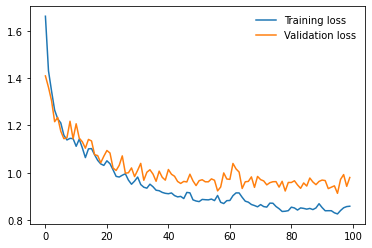

In [165]:
epochs = 100
train_losses, val_losses = [], []

for e in range(epochs):
    running_loss = 0
    for spec, signal in train_loader:
        
        optimizer.zero_grad()
        
        output = meownet(spec)
        loss = loss_fn(output, spec)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        val_loss = 0
        
        with torch.no_grad():
            for spec, signal in test_loader:
                output = meownet(spec)
                val_loss += loss_fn(output, spec).item()
                
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training loss: {:.3f}.. ".format(running_loss / len(train_loader)),
            "Validation loss: {:.3f}..".format(val_loss / len(test_loader))) 
   # scheduler.step()

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [166]:
# Specify a path
path = "state_dict_model.pt"

In [167]:
# Save
torch.save(meownet.state_dict(), path)

## Let's see how this worked. Spectrogram -> raw waveform inference.

In [168]:
# Load
meownet = MeowNet(513).to(device)
meownet.load_state_dict(torch.load(path))

<All keys matched successfully>

In [169]:
def predict(model, spec):
    model.eval()
    with torch.no_grad():
        output = model(spec)
    return output  

## 1) Sample from training set.

In [170]:
# get a sample
rand = random.randint(0, len(train_loader))
spec, signal = [sample[rand] for sample in next(iter(train_loader))]

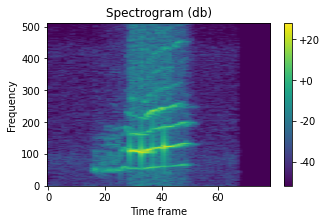

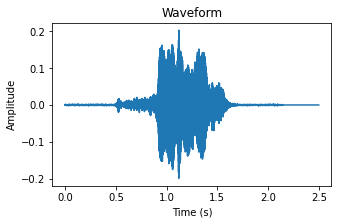

In [171]:
plot_spectrogram(spec)
plot_waveform(signal)
Audio(signal.detach().cpu().numpy(), rate = 8000)

### Waveform reconstruction (training set)

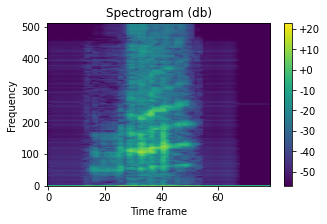

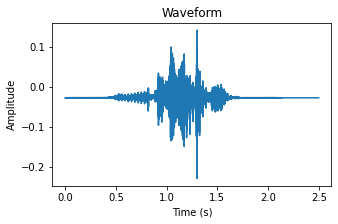

In [172]:
signal_pred = predict(meownet, spec.unsqueeze(0)).squeeze(0)
spec_pred = spectrogram(signal_pred.unsqueeze(0)).squeeze(0)
plot_spectrogram(spec_pred)
plot_waveform(signal_pred)
Audio(signal_pred.detach().cpu().numpy(), rate = 8000)

### 2) Sample from test set.

In [177]:
# get a sample
rand = random.randint(0, len(test_loader))
spec, signal = [sample[rand] for sample in next(iter(test_loader))]

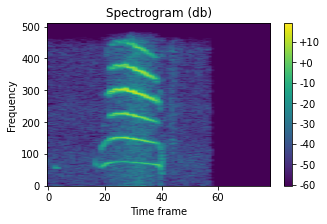

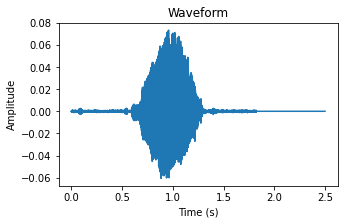

In [178]:
plot_spectrogram(spec)
plot_waveform(signal)
Audio(signal.detach().cpu().numpy(), rate = 8000)

### Waveform inference (test set)

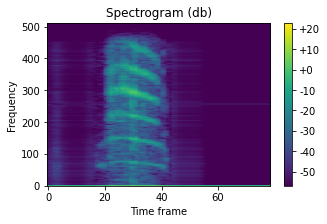

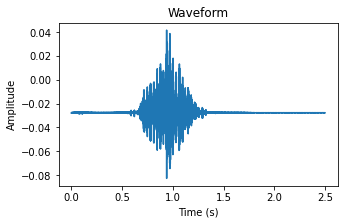

In [179]:
signal_pred = predict(meownet, spec.unsqueeze(0)).squeeze(0)
spec_pred = spectrogram(signal_pred.unsqueeze(0)).squeeze(0)
plot_spectrogram(spec_pred)
plot_waveform(signal_pred)
Audio(signal_pred.detach().cpu().numpy(), rate = 8000)

## Thoughts
- works! (sort of)
- What I'd try with more time:
  - data augmentation (dataset probably a bit small)
  - fine-tuning spectrogram-based loss function
  - model simplification 
  - GAN / RNN model